# Apple Inc. Stock Analysis Using Prophet

## Introduction
In this notebook, I will analyze the stock prices of Apple Inc. using the Prophet forecasting tool. We aim to understand the trends and make predictions about future stock prices.


## Importing the libraries needed for implementation



In [93]:
import os
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from pyspark.sql import SparkSession
import numpy as np
from prophet import Prophet
from joblib import dump
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

## Data Collection
I start by downloading historical stock data for Apple Inc. from Yahoo Finance using the `yfinance` library. The data spans from January 1, 2018, to January 1, 2023. And creat a spark session.

In [94]:

spark = SparkSession.builder.appName("Apple Stock Analysis").getOrCreate()


# Download historical data for Apple Inc. (AAPL)
company_ticker = 'AAPL'
apple_df = yf.download(company_ticker, start="2018-01-01", end="2023-01-01")
apple_df.reset_index(inplace=True)  # Reset index to make 'Date' a column

# Ensure the 'Date' column is the correct datetime format
apple_df['Date'] = pd.to_datetime(apple_df['Date'], errors='coerce')

apple_df.to_csv('apple_stock_data.csv')  # Saving data to CSV for Spark processing and submission
apple_df.head()





[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2018-01-02,40.479832,40.489233,39.774854,39.986349,102223600
1,2018-01-03,40.472782,41.017967,40.409337,40.543281,118071600
2,2018-01-04,40.660774,40.764172,40.437532,40.545627,89738400
3,2018-01-05,41.123707,41.210653,40.665472,40.757119,94640000
4,2018-01-08,40.970970,41.267060,40.872270,40.970970,82271200


## Data Preparation
I process the downloaded data to prepare it for analysis. convert the o/p from yfinance package into data frame(Pandas API) and dropping any null values.


In [95]:
#
apple_df = spark.read.option("header", "true").csv('apple_stock_data.csv')
apple_df = apple_df.withColumn("Close", apple_df["Close"])

#

apple_df = apple_df.toPandas()
apple_df=apple_df.dropna()

apple_df.head()

,Price,Date,Close,High,Low,Open,Volume
1,0,2018-01-02,40.47983169555664,40.48923340934084,39.774853761275736,39.98634929298193,102223600
2,1,2018-01-03,40.472782135009766,41.0179667910744,40.40933670273748,40.543280645459944,118071600
3,2,2018-01-04,40.66077423095703,40.76417156123102,40.43753195097619,40.54562655211502,89738400
4,3,2018-01-05,41.12370681762695,41.21065293604508,40.66547194451393,40.75711891913654,94640000
5,4,2018-01-08,40.970970153808594,41.26705960334316,40.87227008492711,40.970970153808594,82271200


## Moving Averages Calculation
- **Short-term moving average (5 days)**: This gives us insight into the stock's performance over the past week.
- **Long-term moving average (20 days)**: This helps us see the performance over roughly the past month.


In [96]:
#
short_window = 5  # Short-term average window
long_window = 20  # Long-term average window

apple_df['short_ma'] = apple_df['Close'].rolling(window=short_window).mean()
apple_df['long_ma'] = apple_df['Close'].rolling(window=long_window).mean()

# Calculate the previous day's short moving average
apple_df['short_ma_previous'] = apple_df['short_ma'].shift(1)

# Drop NA values that arise from rolling mean calculation
apple_df.dropna(inplace=True)

## Define a signal calculation function

In [97]:

def signal_calc(sma, lma, sma1):
  if (sma > lma) & (sma > sma1):
        return 1
  else:
        if (sma < lma) & (sma < sma1):
            return -1
        else:
            return 0

## Signal Analysis
I defined signals based on the moving averages:
- A **buy signal** is suggested when the short-term average is both above the long-term average and also higher than the previous day's short-term average.
- A **sell signal** is suggested when the short-term average is both below the long-term average and lower than the previous day's short-term average.


In [98]:
apple_df['sma1'] = apple_df['short_ma'].shift(1)

apple_df = apple_df.dropna()

apple_df['signal'] = 0

apple_df['signal'] = apple_df.apply(lambda row: signal_calc(row['short_ma'], row['long_ma'], row['sma1']), axis = 1)


<ipython-input-98-6326cb580aff>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_df['signal'] = 0


## Signal Analysis
Plotting Signals

<Axes: >

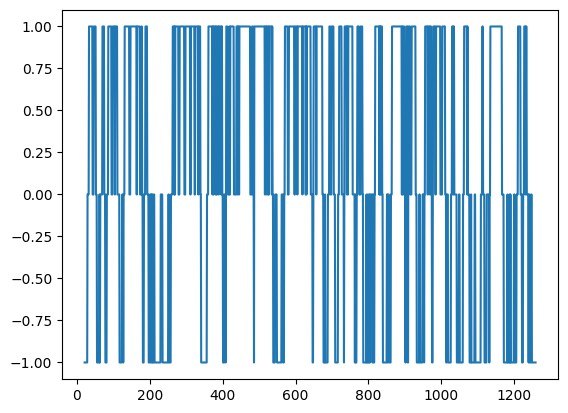

In [99]:
apple_df['signal'].plot()

#Forecasting with Prophet

### Preparing a Prophet DataFrame

In [100]:

forecast_df = pd.DataFrame({'ds': apple_df['Date'], 'y': apple_df["Close"].values})
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'], errors='coerce')  # Explicitly convert to datetime to avoid parsing issues

forecast_df.head(5)


,ds,y
21,2018-01-31,39.34481430053711
22,2018-02-01,39.427066802978516
23,2018-02-02,37.71631622314453
24,2018-02-05,36.77400207519531
25,2018-02-06,38.310855865478516


## Split the data into train and test sets

In [101]:

train_size = int(len(forecast_df) * 0.8)
train_df = forecast_df.iloc[:train_size]
test_df = forecast_df.iloc[train_size:]

## Creating the Seasonality for Prophet

In [102]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.add_seasonality(name='quarterly', period=91.25, fourier_order=5)  # Custom quarterly seasonality
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # Custom monthly seasonality

## Fit the model

In [103]:
model.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpharbbhl0/7ccqy6n9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpharbbhl0/5vab8geu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45137', 'data', 'file=/tmp/tmpharbbhl0/7ccqy6n9.json', 'init=/tmp/tmpharbbhl0/5vab8geu.json', 'output', 'file=/tmp/tmpharbbhl0/prophet_modelk7sekge_/prophet_model-20250305162341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:23:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:23:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Make future dataframe for forecasting

In [104]:
future = model.make_future_dataframe(periods=len(test_df))
forecast = model.predict(future)

## Plot the forecast

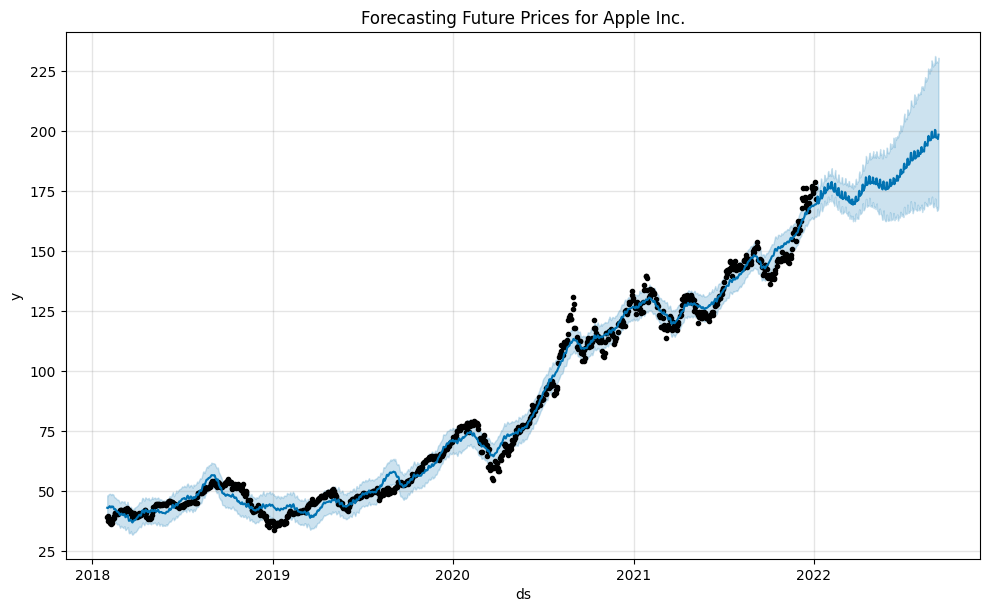

In [105]:
fig = model.plot(forecast)
plt.title('Forecasting Future Prices for Apple Inc.')
plt.show()

##Overview of Forecasting Graph
The graph shows how Apple Inc.'s stock prices might change in the future, according to our predictions. The blue line indicates the expected stock prices, while the black dots represent the actual stock prices from the past. The light blue shaded area around the blue line shows how accurate we think our predictions are, suggesting that the actual future prices could vary within this range.

## Forecast for the next 90 days

In [106]:
future = model.make_future_dataframe(periods=90, freq='D')
forecast = model.predict(future)

             ds        yhat  yhat_lower  yhat_upper
991  2022-01-06  169.778809  164.460269  174.838804
992  2022-01-07  170.053999  164.893340  175.482216
993  2022-01-08  172.873903  167.663226  178.097295
994  2022-01-09  172.721886  167.714503  177.464442
995  2022-01-10  169.907853  164.360704  174.946744
...         ...         ...         ...         ...
1076 2022-04-01  171.389741  164.231709  178.405831
1077 2022-04-02  174.632972  166.945618  182.155994
1078 2022-04-03  175.264477  167.418327  182.679398
1079 2022-04-04  173.026799  165.624732  180.732038
1080 2022-04-05  173.348874  165.774342  181.197234

[90 rows x 4 columns]


['prophet_model.joblib']

## Display the forecasted values for the next 90 days


In [ ]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(90))

## Save the trained model


In [ ]:
dump(model, 'prophet_model.joblib')

## Plot the forecast

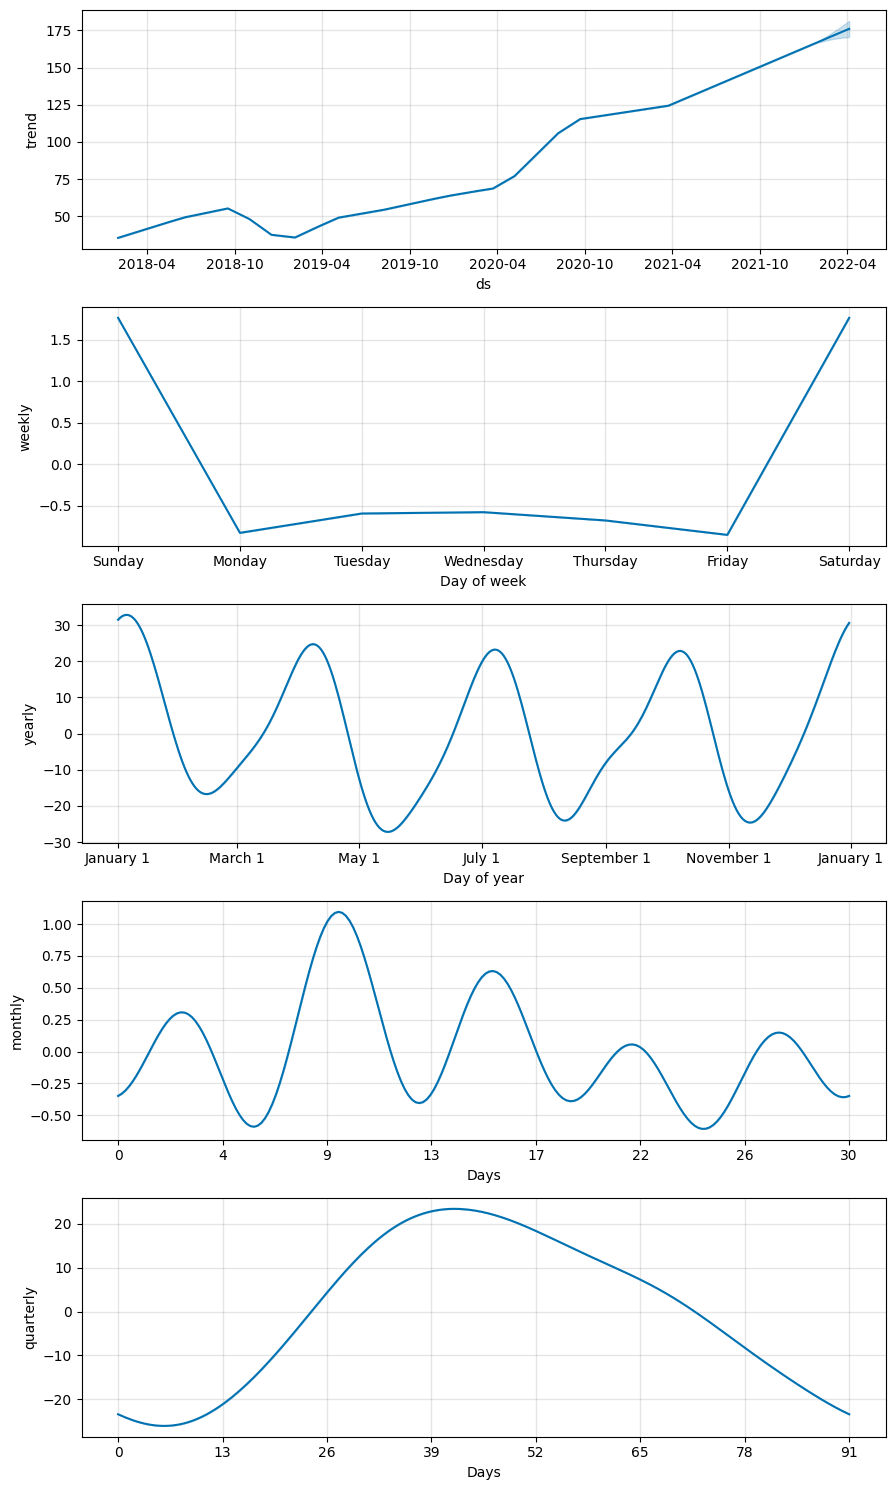

In [107]:
fig2 = model.plot_components(forecast)

## Analysis of Trends
The trend graph reveals that Apple Inc.'s stock prices have been consistently rising over the years from 2018 to 2022. This upward movement suggests that the company is performing well and the market has a positive outlook on its value, expecting continued growth.

##Seasonal Fluctuations Explained
###Yearly Trends:
The stock prices show significant changes throughout the year, with the highest points likely around May and November. These peaks might relate to new product releases and the holiday season, which typically boost sales and stock value.
### Weekly Trends:
The prices tend to be lower at the start of the week and rise as the week progresses. This pattern might be due to investors reacting to news and updates that accumulate over the weekend.
###Monthly and Quarterly Trends:
These smaller ups and downs within each month and quarter might be linked to when Apple reports its earnings and other regular business updates that affect investor sentiment.


##Concluding Insights
This forecast using the Prophet model helps understand the potential future behavior of Apple Inc.'s stock prices by analyzing past trends and seasonal patterns. While the predictions provide a helpful guide for what might happen, they also highlight the risk and uncertainty involved in stock market investments.

The future predictions show that Apple’s stock might continue to increase in value, but with greater uncertainty further into the future, as shown by the wider shaded area in the graph. This suggests while the overall outlook is positive, investors should be cautious, considering this uncertainty in their investment strategies.

#References

Matplotlib Development Team (n.d.) Matplotlib: Visualization with Python. Available at: https://matplotlib.org/stable/contents.html.

Pandas Development Team (n.d.) Pandas: Powerful data structures for data analysis. Available at: https://pandas.pydata.org/docs/.

Apache Spark (n.d.) PySpark Documentation. Available at: https://spark.apache.org/docs/latest/api/python/.

Apache Spark (n.d.) PySpark SQL and DataFrame Guide. Available at: https://spark.apache.org/docs/latest/sql-programming-guide.html.

Facebook (n.d.) Prophet: Forecasting at scale. Available at: https://facebook.github.io/prophet/.